# Hyperparameter optimization of a CNN for XPS data in Keras using Talos

In this notebook, we will search the hyperparameter space of a convolutional network for iron XPS spectra made up of linear combinations of single iron reference spectra using Talos (https://autonomio.github.io/docs_talos/)

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Mounted at /content/drive


### Install packages and import modules

In [2]:
#%%capture
# Install packages
#!pip install git+https://github.com/autonomio/talos@1.0
#!pip install git+git://github.com/lukaspie/talos.git@1.0#egg=talos 

os.chdir('/content/drive/My Drive/app/talos')
!pip install .
os.chdir('/content/drive/My Drive/app')
!pwd
!pip install python-docx

# Import standard modules and magic commands
import tensorflow as tf
import datetime
import numpy as np
import pytz
import importlib
#import talos

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Processing /content/drive/My Drive/app/talos
     |████████████████████████████████| 9.5MB 3.4MB/s 
     |████████████████████████████████| 2.6MB 29.2MB/s 
  Created wheel for talos: filename=talos-1.0-cp36-none-any.whl size=53847 sha256=ba2f2c1b655261060792b4e00a30be10bc707b46424d8de033de5375d72d5b1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldwwbg7n/wheels/75/b8/89/7e6f2baa62b3459799da5d9b70d994d48b6f6ff045d37e22df
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=576d149e707087e5471d788e3b971ce25c738421f10b0ca18b401341e3e8aeb8
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56961 sha256=70fd53b528bf02e7c41edabb8e53ef83d707e4047e47261593e29c9fbcde09b7
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created wheel for chances: filename=chances-0.1.9

In [3]:
try:
    tf.__version__
except:
    tf.VERSION

'2.3.0'

### Load custom modules

In [21]:
try:
    importlib.reload(classifier)
    importlib.reload(opt)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.optimization as opt
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/app/xpsdeeplearning/network/classifier.py'>

<module 'xpsdeeplearning.network.optimization' from '/content/drive/My Drive/app/xpsdeeplearning/network/optimization.py'>

<module 'xpsdeeplearning.network.utils' from '/content/drive/My Drive/app/xpsdeeplearning/network/utils.py'>

Modules were reloaded.


### Set up the parameters & folder structure



In [22]:
seed = 501
np.random.seed(seed)
time = '20201001_13h44m' #datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos'

hyperopt = opt.Hyperoptimization(time, data_name)
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
hyperopt.initialize_clf(label_values)

Test folder was already at /param_tests/20201001_13h44m_Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos
Model folder was already at /saved_models/20201001_13h44m_Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos
Logs folder was already at /logs/20201001_13h44m_Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos
Figures folder was already at /figures/20201001_13h44m_Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


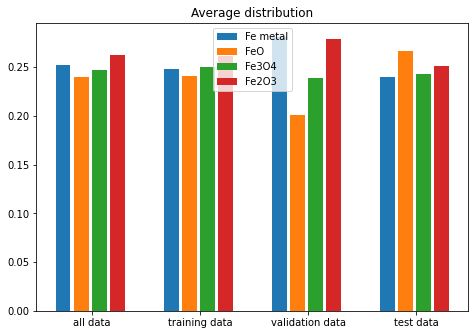

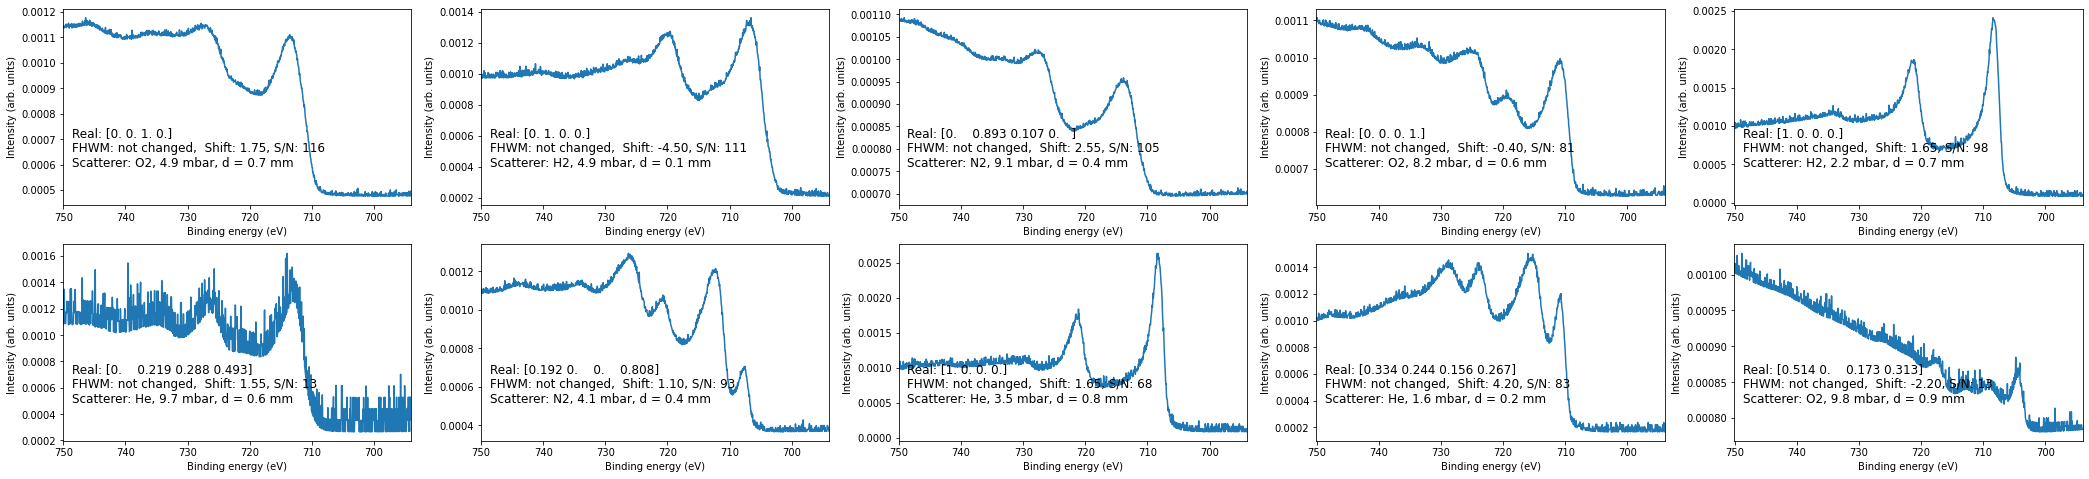

In [23]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200910_iron_variable_linear_combination_gas_phase_combined_data.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000 #5000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        hyperopt.clf.load_data_preprocess(input_filepath = input_filepath,
                                          no_of_examples = no_of_examples,
                                          train_test_split = train_test_split,
                                          train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = hyperopt.clf.check_class_distribution()
hyperopt.clf.plot_class_distribution()
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train')  

## Model design

In [24]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

<module 'xpsdeeplearning.network.models' from '/content/drive/My Drive/app/xpsdeeplearning/network/models.py'>

Models module was reloaded.


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Lambda
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras import backend as K

class CustomCNNTalos(models.EmptyModel):
    def __init__(self, inputshape, num_classes, params):      
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(
            int(params['conv_1_short_filters']),
            int(params['conv_1_short_kernel_size']),
            padding = 'same',
            activation = str(params['conv_1_short_activation']))(input_1)
        conv_1_medium = Conv1D(
            int(params['conv_1_medium_filters']),
            int(params['conv_1_medium_kernel_size']),
            padding = 'same',
            activation = str(params['conv_1_medium_activation']))(input_1)
        conv_1_long = Conv1D(
            int(params['conv_1_long_filters']),
            int(params['conv_1_long_kernel_size']),
            padding = 'same',
            activation = str(params['conv_1_long_activation']))(input_1)
        sublayers = [conv_1_short, conv_1_medium, conv_1_long]
        merged_sublayers = concatenate(sublayers)

        conv_2 = Conv1D(
            int(params['conv_2_filters']),
            int(params['conv_2_kernel_size']),
            padding = 'same',
            activation = str(params['conv_2_activation']))(merged_sublayers)
        conv_3 = Conv1D(
            int(params['conv_3_filters']),
            int(params['conv_3_kernel_size']),
            padding = 'same',
            activation = str(params['conv_3_activation']))(conv_2)
        average_pool_1 = AveragePooling1D()(conv_3)
        flatten_1 = Flatten()(average_pool_1)
        drop_1 = Dropout(float(params['drop_1_rate']))(flatten_1)
        dense_1 = Dense(
            int(params['dense_1_units']),
            activation = str(params['dense_1_activation']))(drop_1)
        dense_2 = Dense(num_classes, activation = 'sigmoid')(dense_1)
        
        output = Lambda(lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                        name = 'normalization')(dense_2)

        no_of_inputs = len(sublayers)

        super(CustomCNNTalos, self).__init__(inputs = input_1,
                                             outputs = output,
                                             inputshape = inputshape,
                                             num_classes = num_classes,
                                             no_of_inputs = no_of_inputs,
                                             name = 'Custom_CNN_Talos')

Model: "Custom_CNN_Talos"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1121, 12)     72          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1121, 12)     132         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1121, 12)     192         input_3[0][0]                    
___________________________________________________________________________________

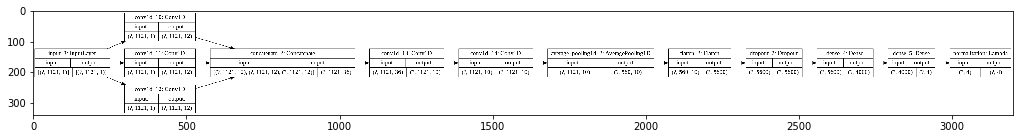

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

init_params = {'conv_1_short_filters' : 12,
               'conv_1_short_kernel_size' : 5,
               'conv_1_short_activation' : 'relu',
               'conv_1_medium_filters' : 12,
               'conv_1_medium_kernel_size' : 10,
               'conv_1_medium_activation' : 'relu',
               'conv_1_long_filters' : 12,
               'conv_1_long_kernel_size' : 15,
               'conv_1_long_activation' : 'relu',
               'conv_2_filters' : 10,
               'conv_2_kernel_size' : 5,
               'conv_2_activation' : 'relu',
               'conv_3_filters' : 10,
               'conv_3_kernel_size' : 5,
               'conv_3_activation' : 'relu',
               'drop_1_rate' : 0.2,
               'dense_1_units' : 4000,
               'dense_1_activation' : 'relu',
               'optimizer' : Adam,
               'learning_rate': 1e-05,
               'loss_function' : MeanAbsoluteError
              }

hyperopt.clf.model = CustomCNNTalos(hyperopt.clf.input_shape,
                                    hyperopt.clf.num_classes,
                                    init_params)

# Compile model with loss function and optimizer from parameter dictionary.
hyperopt.clf.model.compile(
    loss = init_params['loss_function'](),
    optimizer = init_params['optimizer'](init_params['learning_rate']))

# Plot summary and save model plot.
hyperopt.clf.summary()
hyperopt.clf.save_and_print_model_image()

## Hyperparameter optimization

### Parameter Scan

In [27]:
opt_params = {'conv_1_short_filters' : [6, 12, 18],
               'conv_1_short_kernel_size' : [3, 5, 7],
               'conv_1_short_activation' : ['relu'],
               'conv_1_medium_filters' : [6, 12, 18],
               'conv_1_medium_kernel_size' : [8, 10, 12],
                'conv_1_medium_activation' : ['relu'],
               'conv_1_long_filters' : [6, 12, 18],
               'conv_1_long_kernel_size' : [13 ,15, 17],
               'conv_1_long_activation' : ['relu'],
               'conv_2_filters' : [5, 10, 15],
               'conv_2_kernel_size' : [3, 5, 7],
               'conv_2_activation' : ['relu'],
               'conv_3_filters' : [5, 10, 15],
               'conv_3_kernel_size' : [3, 5, 7],
               'conv_3_activation' : ['relu'],
               'drop_1_rate' : [0.1, 0.2],
               'dense_1_units' : [2000, 4000, 6000],
               'dense_1_activation' : ['relu'],
               'optimizer' : [Adam],
               'learning_rate': [1e-05, 3e-04, 1e-04],
               'loss_function' : [MeanAbsoluteError],
               'epochs' : [50],
               'batch_size' : [16, 32]
                }

In [28]:
test_params = {'conv_1_short_filters' : [6, 12],
               'conv_1_short_kernel_size' : [3, 7],
               'conv_1_short_activation' : ['relu'],
               'conv_1_medium_filters' : [6, 12],
               'conv_1_medium_kernel_size' : [8, 12],
                'conv_1_medium_activation' : ['relu'],
               'conv_1_long_filters' : [6, 12],
               'conv_1_long_kernel_size' : [13, 17],
               'conv_1_long_activation' : ['relu'],
               'conv_2_filters' : [8, 12],
               'conv_2_kernel_size' : [5, 10],
               'conv_2_activation' : ['relu'],
               'conv_3_filters' : [8, 12],
               'conv_3_kernel_size' : [5, 10],
               'conv_3_activation' : ['relu'],
               'drop_1_rate' : [0.1],
               'dense_1_units' : [2000, 4000],
               'dense_1_activation' : ['relu'],
               'optimizer' : [Adam],
               'learning_rate': [1e-05],
               'loss_function' : [MeanAbsoluteError],
               'epochs' : [100],
               'batch_size' : [16]
                }

In [29]:
test_params2 = {'conv_1_short_filters' : [6],
               'conv_1_short_kernel_size' : [3],
               'conv_1_short_activation' : ['relu'],
               'conv_1_medium_filters' : [6],
               'conv_1_medium_kernel_size' : [8],
                'conv_1_medium_activation' : ['relu'],
               'conv_1_long_filters' : [6],
               'conv_1_long_kernel_size' : [13],
               'conv_1_long_activation' : ['relu'],
               'conv_2_filters' : [8, 12],
               'conv_2_kernel_size' : [5],
               'conv_2_activation' : ['relu'],
               'conv_3_filters' : [8],
               'conv_3_kernel_size' : [5],
               'conv_3_activation' : ['relu'],
               'drop_1_rate' : [0.1],
               'dense_1_units' : [2000, 4000],
               'dense_1_activation' : ['relu'],
               'optimizer' : [Adam],
               'learning_rate': [1e-05, 1e-04],
               'loss_function' : [MeanAbsoluteError],
               'epochs' : [2],
               'batch_size' : [16]
                }

In [31]:
# RANDOMNESS ARGUMENTS
random_method = 'quantum'

# LIMITER ARGUMENTS
performance_target = None #None or list [metric, threshold, loss or not] 
fraction_limit = None #0.5 # 0.2
round_limit = None # 1000 #int
time_limit = None #'2020-10-01 05:00' #Format "%Y-%m-%d %H:%M". CET -4

# OPTIMIZER ARGUMENTS
reduction_method = 'correlation'
reduction_interval = 30
reduction_window = 20
reduction_threshold = 0.2


hyperopt.scan_parameter_space2(test_params2,
                               random_method = random_method,
                               seed = seed, 
                               performance_target = performance_target,
                               fraction_limit = fraction_limit,
                               round_limit = round_limit,
                               time_limit = time_limit,
                               reduction_method = reduction_method,
                               reduction_interval = reduction_interval,
                               reduction_window = reduction_window,
                               reduction_threshold = reduction_threshold)

  0%|          | 0/8 [00:00<?, ?it/s]

Previous data for Scan 0 was loaded!
{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 8, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 2000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 1e-05, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 12%|█▎        | 1/8 [00:09<01:07,  9.70s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 8, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 2000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 0.0001, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 25%|██▌       | 2/8 [00:18<00:57,  9.53s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 8, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 4000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 1e-05, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 38%|███▊      | 3/8 [00:32<00:54, 10.86s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 8, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 4000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 0.0001, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 50%|█████     | 4/8 [00:50<00:51, 12.79s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 12, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 2000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 1e-05, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 62%|██████▎   | 5/8 [00:59<00:35, 11.71s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 12, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 2000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 0.0001, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 75%|███████▌  | 6/8 [01:08<00:21, 10.98s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 12, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 4000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 1e-05, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


 88%|████████▊ | 7/8 [01:22<00:11, 11.98s/it]

{'batch_size': 16, 'conv_1_long_activation': 'relu', 'conv_1_long_filters': 6, 'conv_1_long_kernel_size': 13, 'conv_1_medium_activation': 'relu', 'conv_1_medium_filters': 6, 'conv_1_medium_kernel_size': 8, 'conv_1_short_activation': 'relu', 'conv_1_short_filters': 6, 'conv_1_short_kernel_size': 3, 'conv_2_activation': 'relu', 'conv_2_filters': 12, 'conv_2_kernel_size': 5, 'conv_3_activation': 'relu', 'conv_3_filters': 8, 'conv_3_kernel_size': 5, 'dense_1_activation': 'relu', 'dense_1_units': 4000, 'drop_1_rate': 0.1, 'epochs': 2, 'learning_rate': 0.0001, 'loss_function': <class 'tensorflow.python.keras.losses.MeanAbsoluteError'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}


100%|██████████| 8/8 [01:37<00:00, 12.14s/it]



 Parameter space was scanned. Training log was saved.
Data was saved to scan archive.


### Analysis of scan results

In [45]:
hyperopt.initialize_analyzer()

# Show the df with the best parameters highlighted.
def _highlight_best(row):
    if row['val_loss'] == hyperopt.analyzer._minimum_value('val_loss'):
        return ['background-color: yellow']*hyperopt.analyzer.df.shape[1]
    else:
        return ['background-color: white']*hyperopt.analyzer.df.shape[1]
    
hyperopt.analyzer.df.style.apply(_highlight_best, axis=1)

,round_epochs,loss,val_loss,batch_size,conv_1_long_activation,conv_1_long_filters,conv_1_long_kernel_size,conv_1_medium_activation,conv_1_medium_filters,conv_1_medium_kernel_size,conv_1_short_activation,conv_1_short_filters,conv_1_short_kernel_size,conv_2_activation,conv_2_filters,conv_2_kernel_size,conv_3_activation,conv_3_filters,conv_3_kernel_size,dense_1_activation,dense_1_units,drop_1_rate,epochs,learning_rate,loss_function,optimizer
0,2,0.221289,0.230875,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,2000,0.100000,2,0.000010,,
1,2,0.221303,0.230786,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,2000,0.100000,2,0.000100,,
2,2,0.221288,0.230867,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,4000,0.100000,2,0.000010,,
3,2,0.221298,0.230764,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,4000,0.100000,2,0.000100,,
4,2,0.221290,0.230876,16,relu,6,13,relu,6,8,relu,6,3,relu,12,5,relu,8,5,relu,2000,0.100000,2,0.000010,,
5,2,0.221287,0.230788,16,relu,6,13,relu,6,8,relu,6,3,relu,12,5,relu,8,5,relu,2000,0.100000,2,0.000100,,
6,2,0.221287,0.230872,16,relu,6,13,relu,6,8,relu,6,3,relu,12,5,relu,8,5,relu,4000,0.100000,2,0.000010,,
7,2,0.221290,0.230783,16,relu,6,13,relu,6,8,relu,6,3,relu,12,5,relu,8,5,relu,4000,0.100000,2,0.000100,,
8,2,0.221290,0.230868,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,2000,0.100000,2,0.000010,,
9,2,0.221291,0.230766,16,relu,6,13,relu,6,8,relu,6,3,relu,8,5,relu,8,5,relu,2000,0.100000,2,0.000100,,


#### Line plot of a chosen metric

In [49]:
importlib.reload(opt)

<module 'xpsdeeplearning.network.optimization' from '/content/drive/My Drive/app/xpsdeeplearning/network/optimization.py'>

File saved to figures directory!


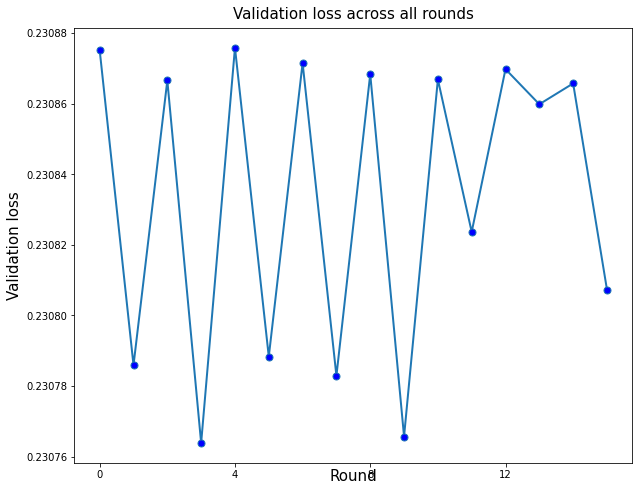

In [50]:
line_data = hyperopt.analyzer.create_line_data(metric = 'val_loss')
line_plot = opt.LinePlot(line_data)
line_plot.plot() 
line_plot.to_file(hyperopt.fig_dir)

#### Histogram of a metric across all rounds

File saved to figures directory!


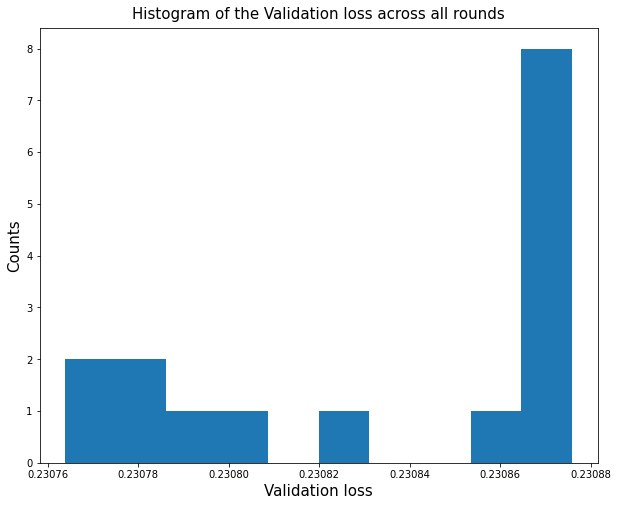

In [51]:
hist_data = hyperopt.analyzer.create_hist_data(metric = 'val_loss')
hist_plot = opt.HistPlot(hist_data)
hist_plot.plot() 
hist_plot.to_file(hyperopt.fig_dir)

#### Correlation matrix

File saved to figures directory!


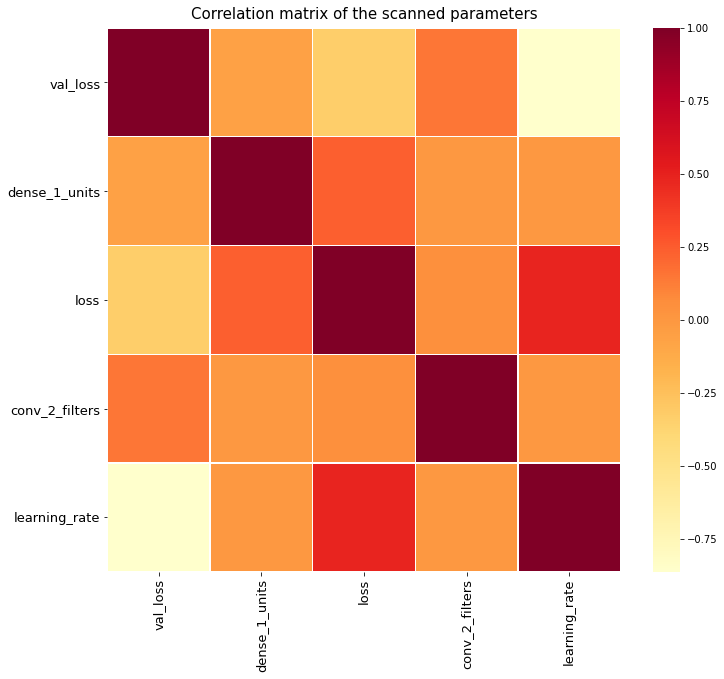

In [52]:
corr_data = hyperopt.analyzer.correlate(metric = 'val_loss')
corr_plot = opt.CorrPlot(corr_data)
corr_plot.plot() 
corr_plot.to_file(hyperopt.fig_dir)

#### Kernel density estimator plot for one metric

File saved to figures directory!


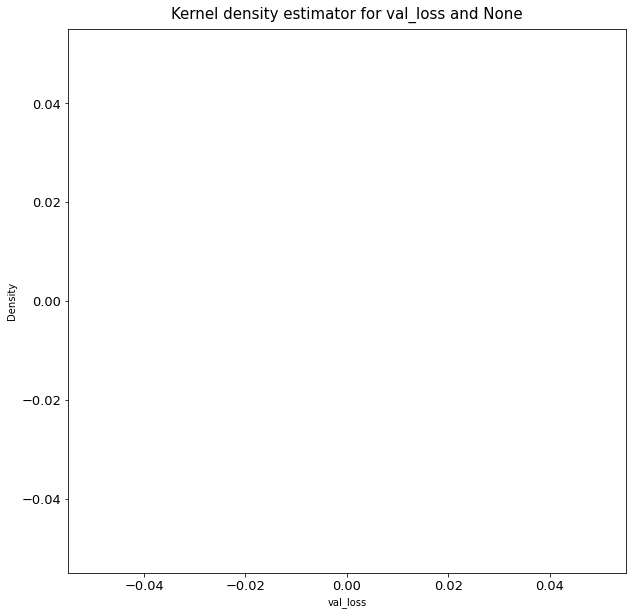

In [53]:
x_kde_1 = 'val_loss'

kde_data_1 = hyperopt.analyzer.create_kde_data(x_kde_1)
kde_plot_1 = opt.KDEPlot(data = kde_data_1,
                         x = x_kde_1)
kde_plot_1.plot()
kde_plot_1.to_file(hyperopt.fig_dir)

#### Kernel density estimator plot for two metrics

File saved to figures directory!


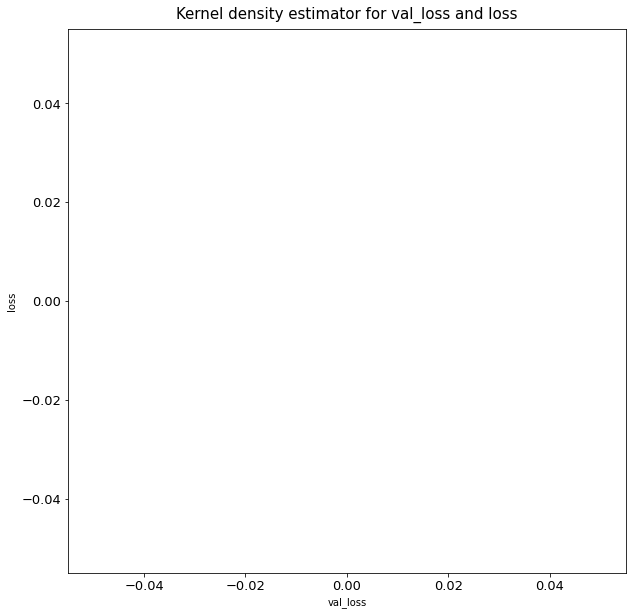

In [54]:
x_kde_2 = 'val_loss'
y_kde_2 = 'loss'

kde_data_2 = hyperopt.analyzer.create_kde_data(x_kde_2,y_kde_2)
kde_plot_2 = opt.KDEPlot(data = kde_data_2,
                              x = x_kde_2,
                              y = y_kde_2)
kde_plot_2.plot()
kde_plot_2.to_file(hyperopt.fig_dir)

#### Bar plot with four parameters

File saved to figures directory!


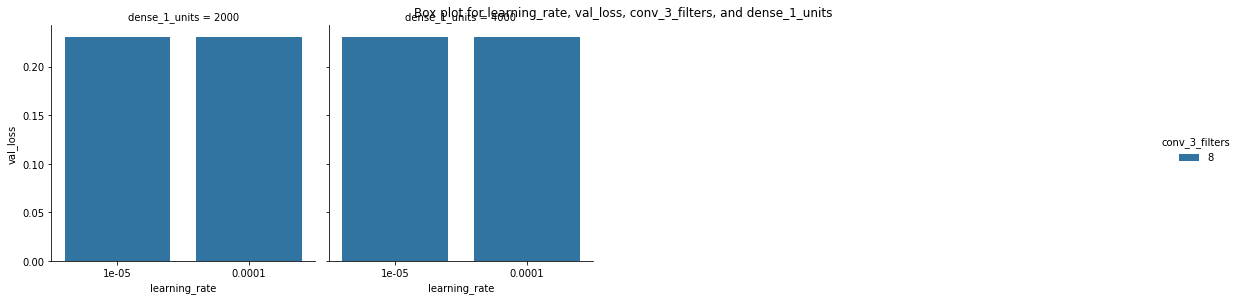

In [55]:
x_bar = 'learning_rate'
y_bar = 'val_loss'
hue_bar = 'conv_3_filters'
col_bar = 'dense_1_units'

#drop_1_rate, , conv_3_kernel_size, dense_1_units

bar_data = hyperopt.analyzer.create_bar_data(x_bar, y_bar, hue_bar, col_bar)
bar_plot = opt.BarPlot(bar_data,
                       x_bar,
                       y_bar,
                       hue_bar,
                       col_bar)
bar_plot.plot()
bar_plot.to_file(hyperopt.fig_dir)

## Training and testing of best model from parameter space

### Load the model with the best performance

In [56]:
metric = 'val_loss'
best_params = hyperopt.get_best_params(metric = metric)
hyperopt.load_model_from_scans(best = True, metric = metric)
# Plot summary and save model plot.
hyperopt.clf.summary()

Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1121, 6)      24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1121, 6)      54          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1121, 6)      84          input_1[0][0]                    
____________________________________________________________________________________________

In [57]:
hyperopt.clf.batch_size = hyperopt.best_params['batch_size']
hyperopt.clf.epochs = hyperopt.best_params['epochs']

### Train with best parameters

In [58]:
epochs = 25 #hyperopt.best_params['epochs']
batch_size = hyperopt.best_params['batch_size']

hist = hyperopt.clf.train(checkpoint = True,
                          early_stopping = False,
                          tb_log = True, 
                          csv_log = True,
                          epochs = epochs, 
                          batch_size = batch_size,
                          verbose = 1)

Epoch 1/25
40/40 [==============================] - ETA: 0s - loss: 0.2213WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20201001_13h44m_Fe_multiple_4_classes_variable_linear_comb_gas_phase_combined_data_talos/assets
40/40 [==============================] - 11s 273ms/step - loss: 0.2213 - val_loss: 0.2308
Epoch 2/25
40/40 [==============================] - 11s 269ms/step - loss: 0.2213 - val_loss: 0.2307
Epoch 3/25
40/40 [==============================] - 8s 196ms/step - loss: 0.2213 - val_loss

### Plot loss after training

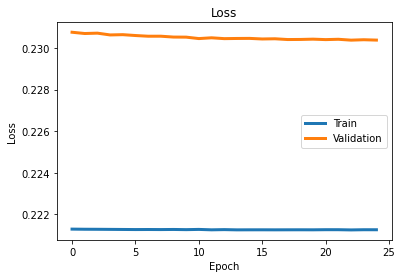

In [59]:
dir_name = hyperopt.clf.time + '_' + hyperopt.clf.data_name
graph = clfutils.TrainingGraphs(hyperopt.clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [60]:
test_loss = hyperopt.clf.evaluate()
print('Test loss: ' + str(test_loss))

13/13 [==============================] - 0s 32ms/step - loss: 0.2250
Evaluation done! 

Test loss: 0.22495274245738983


###  Predict on train and test data

In [61]:
pred_train, pred_test = hyperopt.clf.predict()

7/7 [==============================] - 0s 45ms/step
Prediction done!


###  Save the best model

In [ ]:
hyperopt.clf.save_model()
hyperopt.clf.shelve_results(full = False)

## Save output of notebook

In [63]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
time.sleep(30)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/talos_optimization.ipynb'
output_file = os.path.join(hyperopt.clf.log_dir,'talos_optimization_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
